In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

#### 1. clean data

In [3]:
df = pd.read_csv('crimes_18_22.csv', parse_dates=['Date'], index_col = 2)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head(5)

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,11270455,JB204250,047XX N SPRINGFIELD AVE,2820,OTHER OFFENSE,TELEPHONE THREAT,APARTMENT,False,True,1723,...,39.0,14.0,26,1149537.0,1931176.0,2018,05/04/2018 03:51:04 PM,41.967069,-87.725556,"(41.967068821, -87.7255564)"
2018-01-01,11192879,JB101026,007XX W 61ST PL,0820,THEFT,$500 AND UNDER,TAXICAB,False,False,711,...,16.0,68.0,06,1172324.0,1864087.0,2018,05/04/2018 03:51:04 PM,41.782500,-87.643750,"(41.782497861, -87.64375364)"
2018-01-01,11192880,JB100843,056XX W IRVING PARK RD,0820,THEFT,$500 AND UNDER,RESTAURANT,True,False,1633,...,38.0,15.0,06,1138216.0,1926036.0,2018,05/04/2018 03:51:04 PM,41.953180,-87.767310,"(41.953177006, -87.767307661)"
2018-01-01,11459729,JB452311,087XX S PARNELL AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,"SCHOOL, PUBLIC, BUILDING",False,True,2223,...,21.0,71.0,20,1174165.0,1846893.0,2018,11/22/2018 04:00:54 PM,41.735270,-87.637510,"(41.735274731, -87.637513911)"
2018-01-01,11192882,JB100999,064XX S PAULINA ST,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,False,False,725,...,15.0,67.0,14,1166103.0,1862021.0,2018,05/04/2018 03:51:04 PM,41.776960,-87.666620,"(41.776963134, -87.666620361)"


In [31]:
df.isna().sum()

ID                          0
Case Number                 0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     5392
Arrest                      0
Domestic                    0
Beat                        0
District                    0
Ward                       49
Community Area              1
FBI Code                    0
X Coordinate            22603
Y Coordinate            22603
Year                        0
Updated On                  0
Latitude                22603
Longitude               22603
Location                22603
dtype: int64

##### >> data is ready for analysis

#### 2. records amount analysis

##### 2-1. by day

In [24]:
# combine data by day

# 2018~2022 by day
df_d = pd.DataFrame()
df_d['count_day'] = df['ID'].groupby(df.index).count()

# 2023 by day
df_23 = pd.read_csv('FY_crime_2023.csv', parse_dates=['Date'])

def parse_date(date_str):
    try:
        x = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        return x.date()
    except ValueError:
        try:
            y = datetime.strptime(date_str, "%Y-%m-%d")
            return y.date()
        except ValueError:
            return pd.NaT

df_23['Date'] = df_23['Date'].apply(lambda x: parse_date(str(x)))
df_23['Date'] = pd.to_datetime(df_23['Date'])
df_23 = df_23.set_index('Date')

df_23_d = pd.DataFrame()
df_23_d['count_day'] = df_23['ID'].groupby(df_23.index).count()
df_23_d

# 2018~2023 by day
df_1823_d = pd.concat([df_d, df_23_d], ignore_index=False)
df_1823_d

,count_day
Date,
2018-01-01,992
2018-01-02,562
2018-01-03,576
2018-01-04,602
2018-01-05,666
...,...
2023-12-27,660
2023-12-28,658
2023-12-29,658


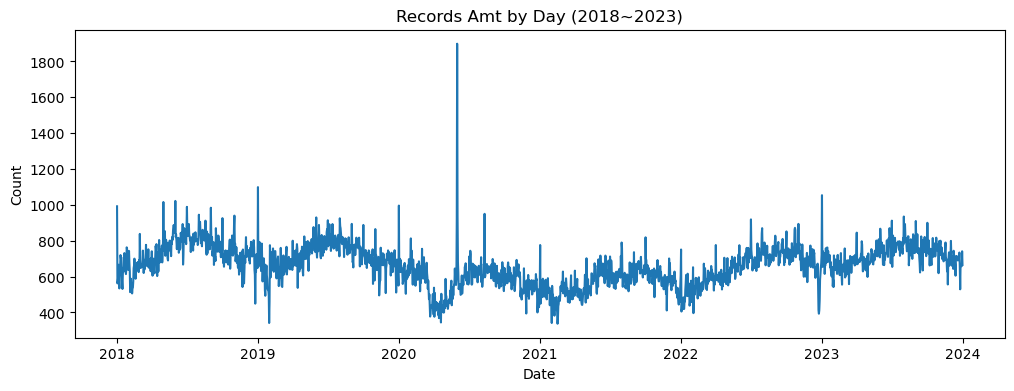

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(df_1823_d.index, df_1823_d['count_day'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Records Amt by Day (2018~2023)')
plt.xticks(rotation=0)  
plt.show()

In [27]:
from statsmodels.tsa.stattools import adfuller
adfuller(df_1823_d['count_day']) #pvalue:0.052, >0.05, not stationary

(-2.8441532670619725,
 0.05223831329961261,
 20,
 2170,
 {'1%': -3.4333670748168506,
  '5%': -2.8628728385507474,
  '10%': -2.567479536622141},
 24086.31360902787)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

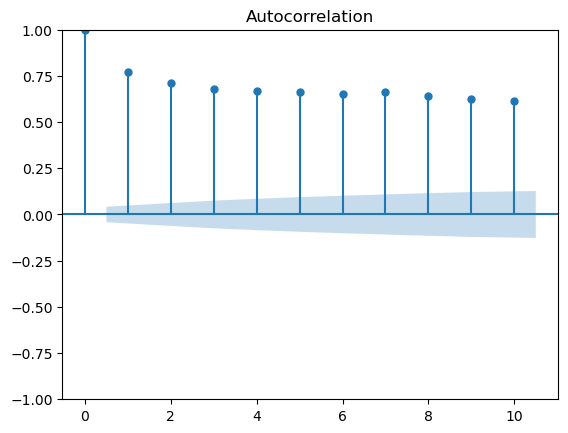

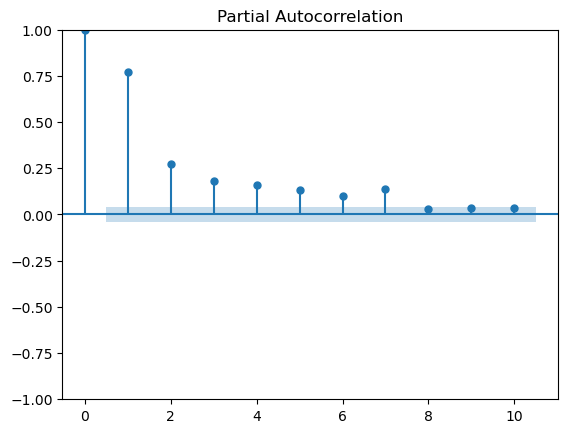

In [41]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df_1823_d.count_day, lags=10), plot_pacf(df_1823_d.count_day, lags=10)

In [56]:
# try arima
df_train = df_1823_d[(df_1823_d.index <= '2023-11-30')]

model_d = pm.auto_arima(df_train.count_day, start_p=0, start_q=0, start_order=0, max_p=5 ,max_q=5, max_order=5, test='adf', seasonal=True) 
print(model_d)  #AR:p=2,I:d=0,MA:q=1
df_predict_d = model_d.predict(n_periods = 30).round(0)
print(df_predict_d)

 ARIMA(2,0,2)(0,0,0)[0]          
2023-12-01    702.0
2023-12-02    700.0
2023-12-03    699.0
2023-12-04    699.0
2023-12-05    698.0
2023-12-06    698.0
2023-12-07    698.0
2023-12-08    698.0
2023-12-09    698.0
2023-12-10    698.0
2023-12-11    698.0
2023-12-12    698.0
2023-12-13    698.0
2023-12-14    698.0
2023-12-15    697.0
2023-12-16    697.0
2023-12-17    697.0
2023-12-18    697.0
2023-12-19    697.0
2023-12-20    697.0
2023-12-21    697.0
2023-12-22    697.0
2023-12-23    697.0
2023-12-24    697.0
2023-12-25    697.0
2023-12-26    697.0
2023-12-27    697.0
2023-12-28    697.0
2023-12-29    697.0
2023-12-30    697.0
Freq: D, dtype: float64


In [57]:
# arima predict data vs real data
df_compare_d = pd.DataFrame(columns=['real_data', 'predict_data', 'deviation', 'dev_rate'])
df_compare_d.index = (pd.to_datetime(df_compare_d.index,format='%Y%m%d')).normalize()

df_compare_d['real_data'] = df_1823_d[(df_1823_d.index >= '2023-12-01')&(df_1823_d.index <= '2023-12-30')]
df_compare_d['predict_data'] = df_predict_d.round(0).astype(int)
df_compare_d['deviation'] = df_compare_d['predict_data']- df_compare_d['real_data']
df_compare_d['dev_rate'] = df_compare_d['deviation']/df_compare_d['real_data']
df_compare_d['dev_rate'] = df_compare_d['dev_rate'].round(2)
df_compare_d

,real_data,predict_data,deviation,dev_rate
Date,,,,
2023-12-01,799,702,-97,-0.12
2023-12-02,718,700,-18,-0.03
2023-12-03,665,699,34,0.05
2023-12-04,711,699,-12,-0.02
2023-12-05,658,698,40,0.06
2023-12-06,660,698,38,0.06
2023-12-07,643,698,55,0.09
2023-12-08,744,698,-46,-0.06
2023-12-09,723,698,-25,-0.03


In [100]:
import openpyxl
df_compare_d.to_excel("df_compare_d.xlsx",index=True)

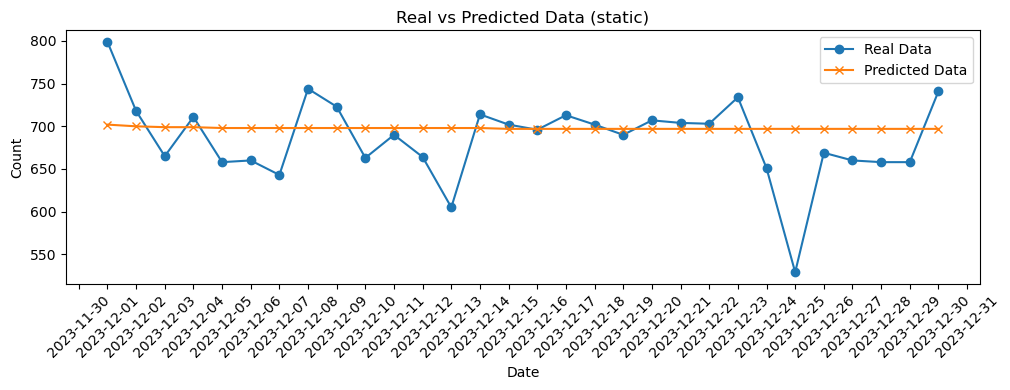

In [23]:
# plot arima predict data vs real data
plt.figure(figsize=(10, 4))
plt.plot(df_compare_d.index, df_compare_d['real_data'], label='Real Data', marker='o')
plt.plot(df_compare_d.index, df_compare_d['predict_data'], label='Predicted Data', marker='x')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Real vs Predicted Data (static)')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.show()

In [87]:
print(df_compare_d['dev_rate'].median())
print(df_compare_d['dev_rate'].mean())

0.005
0.022666666666666672


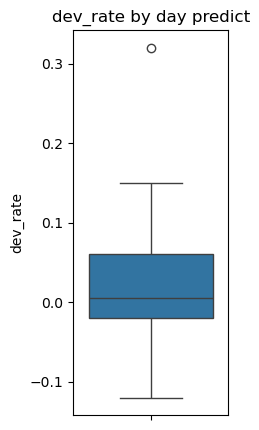

In [22]:

plt.figure(figsize=(2, 5))

sns.boxplot(y='dev_rate',data=df_compare_d)
plt.title('dev_rate by day predict')
plt.show()

##### >> the trend is not clear. 
##### >> try to predict by month.

##### 2-2. by month

In [28]:
# combine data by month

# 2018~2022 by month
df_m = pd.DataFrame()
df_m['count_month'] = df['ID'].groupby([df.index.year,df.index.month]).count()

# 2023 by month
df_23 = pd.read_csv('FY_crime_2023.csv', parse_dates=['Date'])

def parse_date(date_str):
    try:
        x = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        return x.date()
    except ValueError:
        try:
            y = datetime.strptime(date_str, "%Y-%m-%d")
            return y.date()
        except ValueError:
            return pd.NaT

df_23['Date'] = df_23['Date'].apply(lambda x: parse_date(str(x)))
df_23['Date'] = pd.to_datetime(df_23['Date'])
df_23 = df_23.set_index('Date')

df_23_m = pd.DataFrame()
df_23_m['count_month'] = df_23['ID'].groupby([df_23.index.year,df_23.index.month]).count()
df_23_m

# 2018~2023 by month
df_1823_m = pd.concat([df_m, df_23_m], ignore_index=False)
df_1823_m.index = df_1823_m.index.set_names(['year', 'month'])
df_1823_m = df_1823_m.reset_index()
df_1823_m['Date'] = pd.to_datetime(df_1823_m[['year', 'month']].assign(day=1))
df_1823_m = df_1823_m[['Date', 'count_month']]
df_1823_m['Date'] = df_1823_m['Date'].dt.strftime('%Y-%m')
df_1823_m.set_index('Date',inplace=True)

df_1823_m

,count_month
Date,
2018-01,20567
2018-02,17366
2018-03,21253
2018-04,21161
2018-05,24755
...,...
2023-08,24155
2023-09,22608
2023-10,23037


In [32]:
df_1823_m.index

Index(['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
       '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12',
       '2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
       '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12'],
      dtype='object', name='Date')

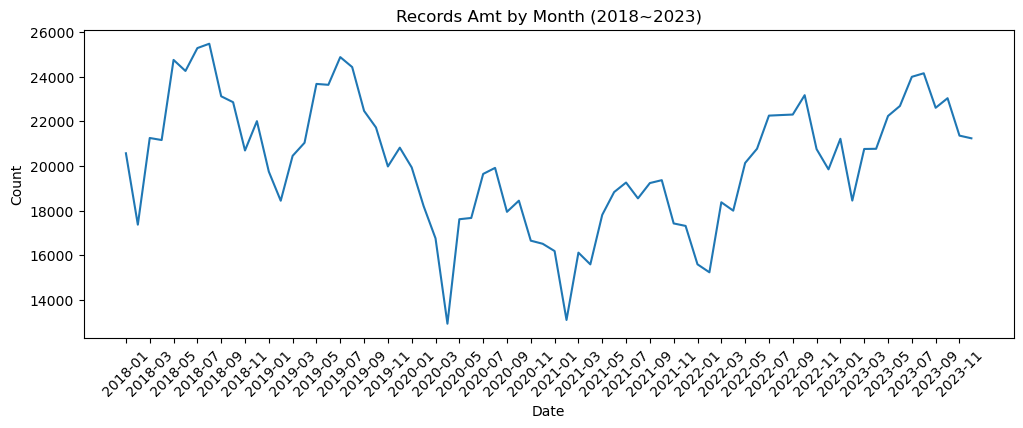

In [36]:
plt.figure(figsize=(12, 4))
plt.plot(df_1823_m.index, df_1823_m['count_month'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Records Amt by Month (2018~2023)')
plt.xticks(ticks=range(0, len(df_1823_m), 2),rotation=45)  
plt.show()

In [37]:
from statsmodels.tsa.stattools import adfuller
adfuller(df_1823_m['count_month']) #pvalue:0.6302, >0.05, not stationary

(-1.297634881191112,
 0.6302536625494238,
 12,
 59,
 {'1%': -3.5463945337644063,
  '5%': -2.911939409384601,
  '10%': -2.5936515282964665},
 1023.231810278228)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

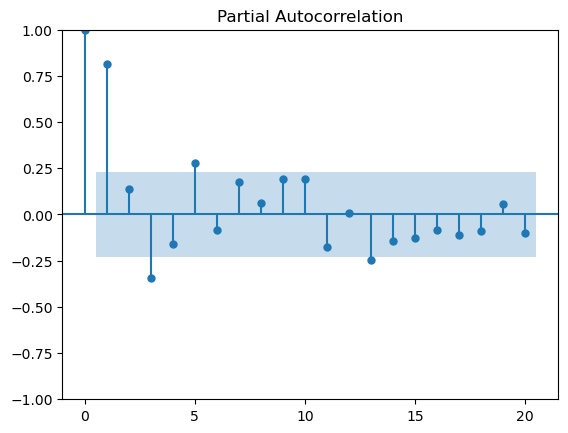

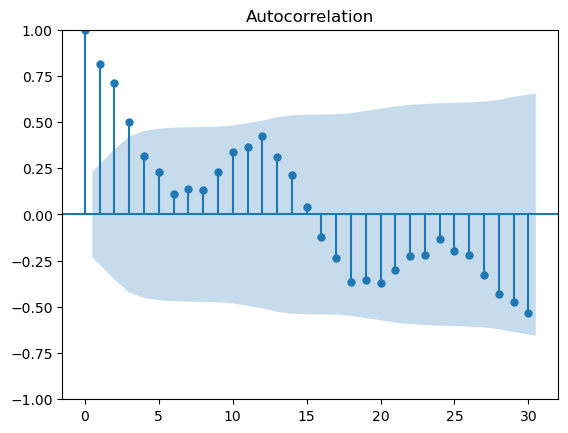

In [39]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_pacf(df_1823_m.count_month, lags=20), plot_acf(df_1823_m.count_month, lags=30)

In [51]:
# try arima
df_train = df_1823_m[(df_1823_m.index <= '2022-12')]

model_m = pm.auto_arima(df_train.count_month, start_p=0, start_q=0, start_order=0, max_p=5 ,max_q=5, max_order=5, test='adf', seasonal=True)
df_predict_m = model_m.predict(n_periods = 12)
df_predict_m.round(0).astype(int) 

2023-01-01    19846
2023-02-01    19847
2023-03-01    19847
2023-04-01    19847
2023-05-01    19848
2023-06-01    19848
2023-07-01    19848
2023-08-01    19848
2023-09-01    19848
2023-10-01    19848
2023-11-01    19848
2023-12-01    19848
Freq: MS, dtype: int64

In [44]:
# try sarima
order = model_m.order
seasonal_order = model_m.seasonal_order
sarima_model_m = SARIMAX(df_train.count_month, order=order, seasonal_order=seasonal_order)
sarima_result_m = sarima_model_m.fit()
#print(sarima_result_m.summary)

df_predict_sm = sarima_result_m.forecast(steps=12)
df_predict_sm.round(0)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.95442D+00    |proj g|=  3.40837D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      4      1     0     0   4.356D-07   8.954D+00
  F =   8.9542891866658341     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


2023-01-01    19767.0
2023-02-01    19688.0
2023-03-01    19610.0
2023-04-01    19532.0
2023-05-01    19454.0
2023-06-01    19377.0
2023-07-01    19299.0
2023-08-01    19223.0
2023-09-01    19146.0
2023-10-01    19070.0
2023-11-01    18994.0
2023-12-01    18918.0
Freq: MS, Name: predicted_mean, dtype: float64

In [53]:
# arima predict data vs real data
df_compare_m = pd.DataFrame()
df_compare_m.index = (pd.to_datetime(df_compare_m.index,format='%Y%m')).normalize()

df_compare_m['real_data'] = df_1823_m[(df_1823_m.index >= '2023-01')]
df_predict_m = df_predict_m.round(0).astype(int).tolist()
df_compare_m['predict_data'] = df_predict_m
df_compare_m['deviation'] = df_compare_m['predict_data']- df_compare_m['real_data']
df_compare_m['dev_rate'] = (df_compare_m['deviation']/df_compare_m['real_data']).round(2)
df_compare_m

,real_data,predict_data,deviation,dev_rate
Date,,,,
2023-01,21217,19846,-1371,-0.06
2023-02,18445,19847,1402,0.08
2023-03,20760,19847,-913,-0.04
2023-04,20768,19847,-921,-0.04
2023-05,22240,19848,-2392,-0.11
2023-06,22689,19848,-2841,-0.13
2023-07,23997,19848,-4149,-0.17
2023-08,24155,19848,-4307,-0.18
2023-09,22608,19848,-2760,-0.12


In [58]:
# sarima predict data vs real data
df_compare_sm = pd.DataFrame()
df_compare_sm.index = (pd.to_datetime(df_compare_sm.index,format='%Y%m')).normalize()

df_compare_sm['real_data'] = df_1823_m[(df_1823_m.index >= '2023-01')]
df_predict_sm = df_predict_sm.round(0).astype(int).tolist()
df_compare_sm['predict_data'] = df_predict_sm

df_compare_sm['deviation'] = df_compare_sm['predict_data']- df_compare_sm['real_data']
df_compare_sm['dev_rate'] = (df_compare_sm['deviation']/df_compare_sm['real_data']).round(2)
df_compare_sm

,real_data,predict_data,deviation,dev_rate
Date,,,,
2023-01,21217,19767,-1450,-0.07
2023-02,18445,19688,1243,0.07
2023-03,20760,19610,-1150,-0.06
2023-04,20768,19532,-1236,-0.06
2023-05,22240,19454,-2786,-0.13
2023-06,22689,19377,-3312,-0.15
2023-07,23997,19299,-4698,-0.20
2023-08,24155,19223,-4932,-0.20
2023-09,22608,19146,-3462,-0.15


In [101]:
df_compare_m.to_excel("df_compare_m.xlsx",index=True)

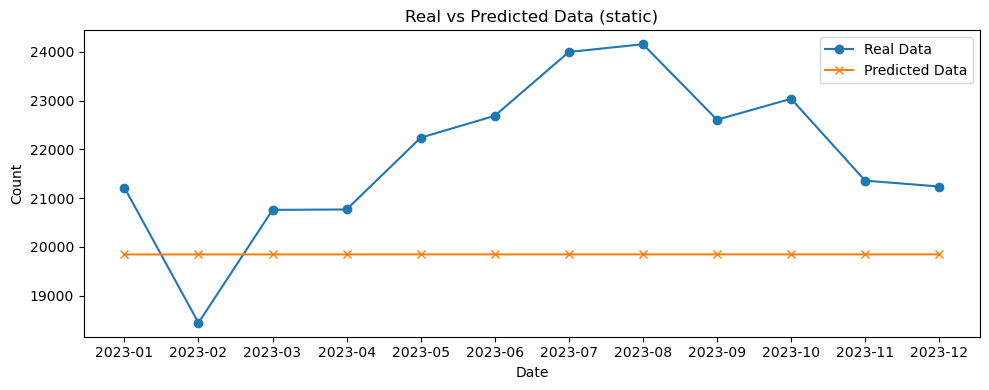

In [79]:
# plot arima
plt.figure(figsize=(10, 4))
plt.plot(df_compare_m.index, df_compare_m['real_data'], label='Real Data', marker='o')
plt.plot(df_compare_m.index, df_compare_m['predict_data'], label='Predicted Data', marker='x')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Real vs Predicted Data (static)')
plt.legend()
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()


In [88]:
print(df_compare_m['dev_rate'].median())
print(df_compare_m['dev_rate'].mean())

-0.09
-0.08750000000000001


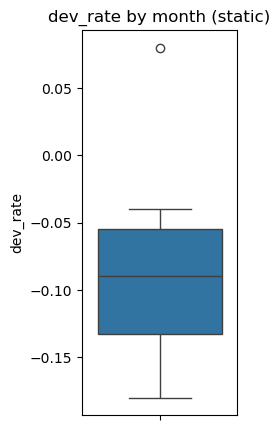

In [65]:
plt.figure(figsize=(2, 5))

sns.boxplot(y='dev_rate',data=df_compare_m)
plt.title('dev_rate by month (static)')
plt.show()

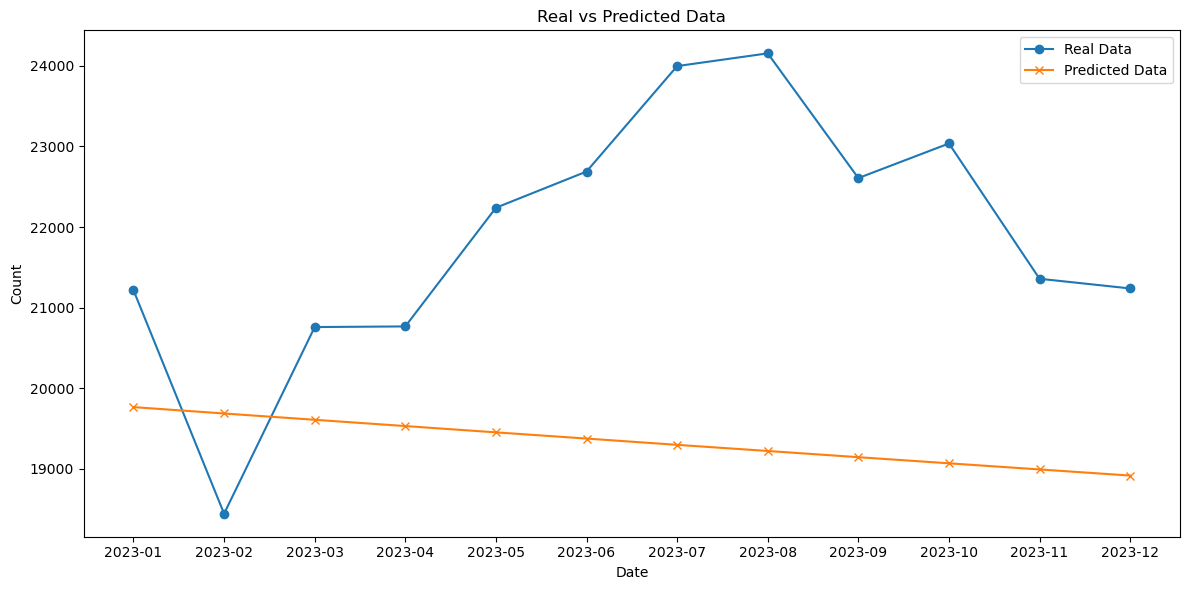

In [61]:
# plot sarima
plt.figure(figsize=(12, 6))
plt.plot(df_compare_sm.index, df_compare_sm['real_data'], label='Real Data', marker='o')
plt.plot(df_compare_sm.index, df_compare_sm['predict_data'], label='Predicted Data', marker='x')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Real vs Predicted Data')
plt.legend()
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

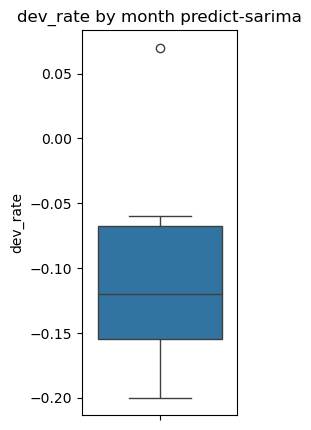

In [62]:
plt.figure(figsize=(2, 5))

sns.boxplot(y='dev_rate',data=df_compare_sm)
plt.title('dev_rate by month predict-sarima')
plt.show()

##### >> the deviation and rate are large. trend can not be predicted.
##### >> try to do dynamic prediction. use the past 30 days data to predict next day.

##### 2-3. dynamic predict

#####  2-3-1 per 30 days

###### test

In [18]:
'''
2022-12.1~30 >> 2023.12.31
2022-12.2~31 >> 2023.1.1
2022-12.3~1.1 >> 2023.1.2
......
'''
df_compare_30 = pd.DataFrame(columns=['real_data', 'predict_data', 'deviation', 'dev_rate'])

for i in range(30):
    df_train = df_d[(df_d.index >= '2022-11-01') & (df_d.index <= '2022-12-30')]
    df_train = df_train.iloc[i:i+30]
    model_30 = pm.auto_arima(df_train, start_p=0, start_q=0, start_order=0, max_p=5 ,max_q=5, max_order=5, test='adf', seasonal=True) 
    df_predict = model_30.predict(n_periods = 1)

    time = (pd.to_datetime('2022-12-01') + pd.Timedelta(days=i)).normalize()

    real_data = df_d.loc[time,'count_day']
    predict_data = int(df_predict[0].round(0))
    deviation = predict_data - real_data
    dev_rate = (deviation / real_data).round(2)

    df_compare_30.loc[time] = [real_data, predict_data, deviation, dev_rate]

print(df_compare_30)


/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_7200/3786350922.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))
/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_7200/3786350922.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))
/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_7200/3786350922.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value b

            real_data  predict_data  deviation  dev_rate
2022-12-01      740.0         680.0      -60.0     -0.08
2022-12-02      773.0         703.0      -70.0     -0.09
2022-12-03      653.0         731.0       78.0      0.12
2022-12-04      689.0         698.0        9.0      0.01
2022-12-05      680.0         693.0       13.0      0.02
2022-12-06      754.0         690.0      -64.0     -0.08
2022-12-07      745.0         702.0      -43.0     -0.06
2022-12-08      715.0         714.0       -1.0     -0.00
2022-12-09      650.0         693.0       43.0      0.07
2022-12-10      750.0         674.0      -76.0     -0.10
2022-12-11      719.0         684.0      -35.0     -0.05
2022-12-12      733.0         682.0      -51.0     -0.07
2022-12-13      675.0         683.0        8.0      0.01
2022-12-14      636.0         720.0       84.0      0.13
2022-12-15      593.0         751.0      158.0      0.27
2022-12-16      653.0         669.0       16.0      0.02
2022-12-17      645.0         6

/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_7200/3786350922.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))


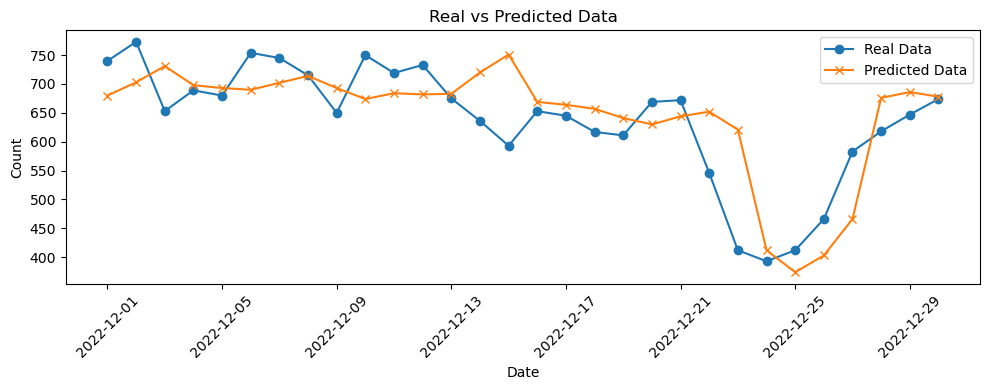

In [19]:
plt.figure(figsize=(10, 4))

plt.plot(df_compare_30.index, df_compare_30['real_data'], label='Real Data', marker='o')
plt.plot(df_compare_30.index, df_compare_30['predict_data'], label='Predicted Data', marker='x')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Real vs Predicted Data')

plt.legend()

plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

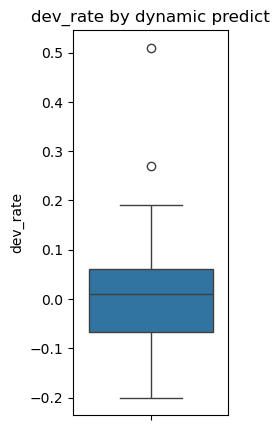

In [20]:
plt.figure(figsize=(2, 5))

sns.boxplot(y='dev_rate',data=df_compare_30)
plt.title('dev_rate by dynamic predict')
plt.show()

###### >> the accuracy is high. the model can be used to predict.

##### 2023-11-01~11-30 >> 2023-12-01; 2023-11-02~12-01 >> 2023-12-02; 2023-11-03~12-02 >> 2023-12-03...

In [66]:
df_23 = pd.read_csv('FY_crime_2023.csv', parse_dates=['Date'])

def parse_date(date_str):
    try:
        x = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        return x.date()
    except ValueError:
        try:
            y = datetime.strptime(date_str, "%Y-%m-%d")
            return y.date()
        except ValueError:
            return pd.NaT

df_23['Date'] = df_23['Date'].apply(lambda x: parse_date(str(x)))
df_23['Date'] = pd.to_datetime(df_23['Date'])
df_23 = df_23.set_index('Date')

#df_23.head(5)

df_23_d = pd.DataFrame()
df_23_d['count_day'] = df_23['ID'].groupby(df_23.index).count()
df_23_d.tail(5)

,count_day
Date,
2023-12-27,660
2023-12-28,658
2023-12-29,658
2023-12-30,741
2023-12-31,665


In [95]:
df_compare_30 = pd.DataFrame(columns=['real_data', 'predict_data', 'deviation', 'dev_rate'])

for i in range(30):
    df_train = df_23_d[(df_23_d.index >= '2023-11-01')]
    df_train = df_train.iloc[i:i+30]
    model_30 = pm.auto_arima(df_train, start_p=0, start_q=0, start_order=0, max_p=5 ,max_q=5, max_order=5, test='adf', seasonal=True) 
    df_predict = model_30.predict(n_periods = 1)

    time = (pd.to_datetime('2023-12-01') + pd.Timedelta(days=i)).normalize()

    real_data = df_23_d.loc[time,'count_day']
    predict_data = int(df_predict[0].round(0))
    deviation = predict_data - real_data
    dev_rate = (deviation / real_data).round(2)

    df_compare_30.loc[time] = [real_data, predict_data, deviation, dev_rate]

print(df_compare_30)


/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_10400/3670958834.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))
/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_10400/3670958834.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))
/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_10400/3670958834.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

            real_data  predict_data  deviation  dev_rate
2023-12-01      799.0         701.0      -98.0     -0.12
2023-12-02      718.0         765.0       47.0      0.07
2023-12-03      665.0         764.0       99.0      0.15
2023-12-04      711.0         657.0      -54.0     -0.08
2023-12-05      658.0         709.0       51.0      0.08
2023-12-06      660.0         689.0       29.0      0.04
2023-12-07      643.0         654.0       11.0      0.02
2023-12-08      744.0         621.0     -123.0     -0.17
2023-12-09      723.0         749.0       26.0      0.04
2023-12-10      663.0         768.0      105.0      0.16
2023-12-11      690.0         684.0       -6.0     -0.01
2023-12-12      664.0         690.0       26.0      0.04
2023-12-13      605.0         673.0       68.0      0.11
2023-12-14      714.0         597.0     -117.0     -0.16
2023-12-15      702.0         683.0      -19.0     -0.03
2023-12-16      696.0         724.0       28.0      0.04
2023-12-17      713.0         6

/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_10400/3670958834.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))


In [102]:
df_compare_30.to_excel("df_compare_30.xlsx",index=True)

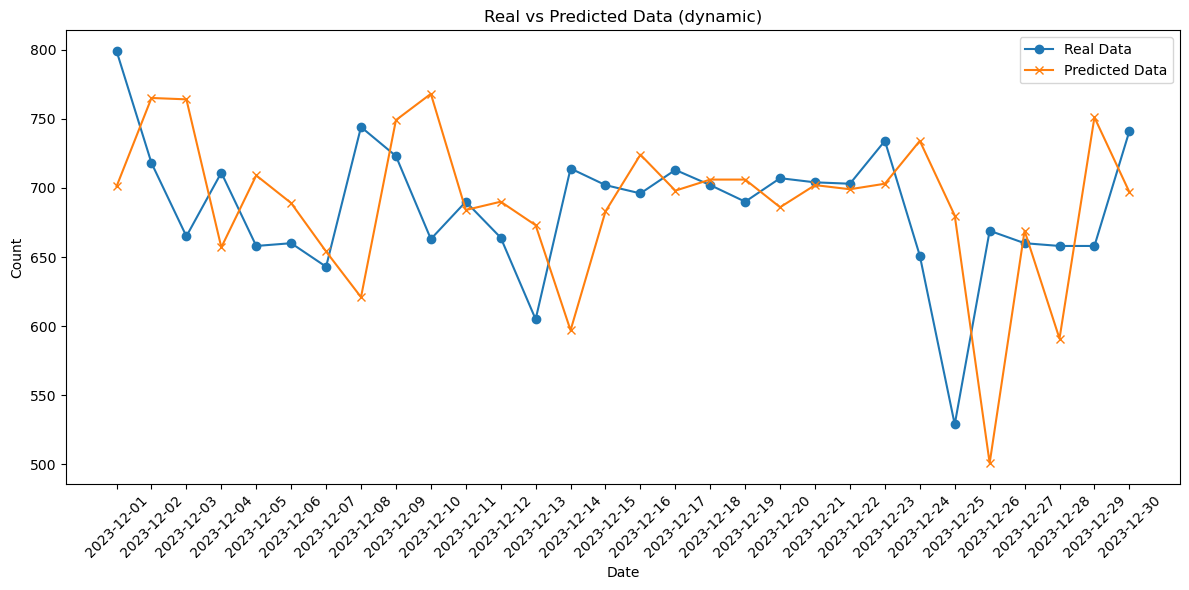

In [90]:
plt.figure(figsize=(12, 6))

plt.plot(df_compare_30.index, df_compare_30['real_data'], label='Real Data', marker='o')
plt.plot(df_compare_30.index, df_compare_30['predict_data'], label='Predicted Data', marker='x')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Real vs Predicted Data (dynamic)')

plt.legend()

plt.xticks(df_compare_30.index,rotation=45) 
plt.tight_layout()
plt.show()

In [93]:
print(df_compare_30['dev_rate'].median())
print(df_compare_30['dev_rate'].mean())

0.01
0.009000000000000003


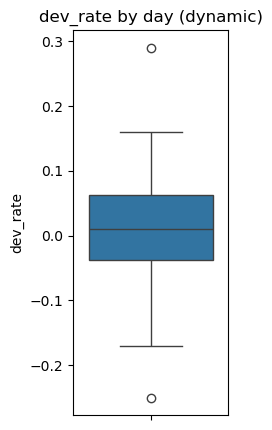

In [71]:
plt.figure(figsize=(2, 5))

sns.boxplot(y='dev_rate',data=df_compare_30)
plt.title('dev_rate by day (dynamic)')
plt.show()

##### >> the median of deviation rate is almost 0.0, and the rates are mostly in 10%, even 5%.

In [72]:
df_train = df_23_d[(df_23_d.index >= '2023-12-02')]
model_30 = pm.auto_arima(df_train, start_p=0, start_q=0, start_order=0, max_p=5 ,max_q=5, max_order=5, test='adf', seasonal=True) 
df_predict = model_30.predict(n_periods = 1)
df_predict.round(0).astype(int)

2024-01-01    686
Freq: D, dtype: int64

##### >> predict: on 2024-1-1, there will be 686 records in Chicago. 

#####  2-3-2 per 12 months

In [73]:
df_m = pd.DataFrame()
df_m['count_month'] = df['ID'].groupby([df.index.year,df.index.month]).count()
df_m.head(5)

count_month
Date Date             
2018 1           20567
     2           17366
     3           21253
     4           21161
     5           24755

In [74]:
df_23 = pd.read_csv('FY_crime_2023.csv', parse_dates=['Date'])

def parse_date(date_str):
    try:
        x = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        return x.date()
    except ValueError:
        try:
            y = datetime.strptime(date_str, "%Y-%m-%d")
            return y.date()
        except ValueError:
            return pd.NaT

df_23['Date'] = df_23['Date'].apply(lambda x: parse_date(str(x)))
df_23['Date'] = pd.to_datetime(df_23['Date'])
df_23 = df_23.set_index('Date')

#df_23.head(5)

df_23_m = pd.DataFrame()
df_23_m['count_month'] = df_23['ID'].groupby([df_23.index.year,df_23.index.month]).count()
df_23_m

count_month
Date Date             
2023 1           21217
     2           18445
     3           20760
     4           20768
     5           22240
     6           22689
     7           23997
     8           24155
     9           22608
     10          23037
     11          21359
     12          21239

In [75]:
df_1823_m = pd.concat([df_m, df_23_m], ignore_index=False)
df_1823_m.index = df_1823_m.index.set_names(['year', 'month'])
df_1823_m = df_1823_m.reset_index()
df_1823_m['Date'] = pd.to_datetime(df_1823_m[['year', 'month']].assign(day=1))
df_1823_m = df_1823_m[['Date', 'count_month']]
df_1823_m['Date'] = df_1823_m['Date'].dt.strftime('%Y-%m')
df_1823_m.set_index('Date',inplace=True)

df_1823_m

,count_month
Date,
2018-01,20567
2018-02,17366
2018-03,21253
2018-04,21161
2018-05,24755
...,...
2023-08,24155
2023-09,22608
2023-10,23037


In [76]:
df_compare_12 = pd.DataFrame(columns=['real_data', 'predict_data', 'deviation', 'dev_rate'])

for i in range(12):
    df_train = df_1823_m[(df_1823_m.index >= '2022-01')]
    df_train = df_train.iloc[i:i+12]
    model_12 = pm.auto_arima(df_train, start_p=0, start_q=0, start_order=0, max_p=5 ,max_q=5, max_order=5, test='adf', seasonal=True) 
    df_predict = model_12.predict(n_periods = 1)

    time = (pd.to_datetime('2023-01') + pd.DateOffset(months=i)).normalize()

    real_data = df_1823_m.loc[time.strftime('%Y-%m'), 'count_month']
    predict_data = int(df_predict[0].round(0))
    deviation = predict_data - real_data
    dev_rate = (deviation / real_data).round(2)

    df_compare_12.loc[time.strftime('%Y-%m')] = [real_data, predict_data, deviation, dev_rate]

print(df_compare_12)


/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_10400/1723775702.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))
/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_10400/1723775702.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))
/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_10400/1723775702.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a valu

         real_data  predict_data  deviation  dev_rate
2023-01    21217.0       17396.0    -3821.0     -0.18
2023-02    18445.0       22588.0     4143.0      0.22
2023-03    20760.0       18445.0    -2315.0     -0.11
2023-04    20768.0       23075.0     2307.0      0.11
2023-05    22240.0       21087.0    -1153.0     -0.05
2023-06    22689.0       23712.0     1023.0      0.05
2023-07    23997.0       23138.0     -859.0     -0.04
2023-08    24155.0       25305.0     1150.0      0.05
2023-09    22608.0       24313.0     1705.0      0.08
2023-10    23037.0       21510.0    -1527.0     -0.07
2023-11    21359.0       23194.0     1835.0      0.09
2023-12    21239.0       19681.0    -1558.0     -0.07


/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_10400/1723775702.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))


In [103]:
df_compare_12.to_excel("df_compare_12.xlsx",index=True)

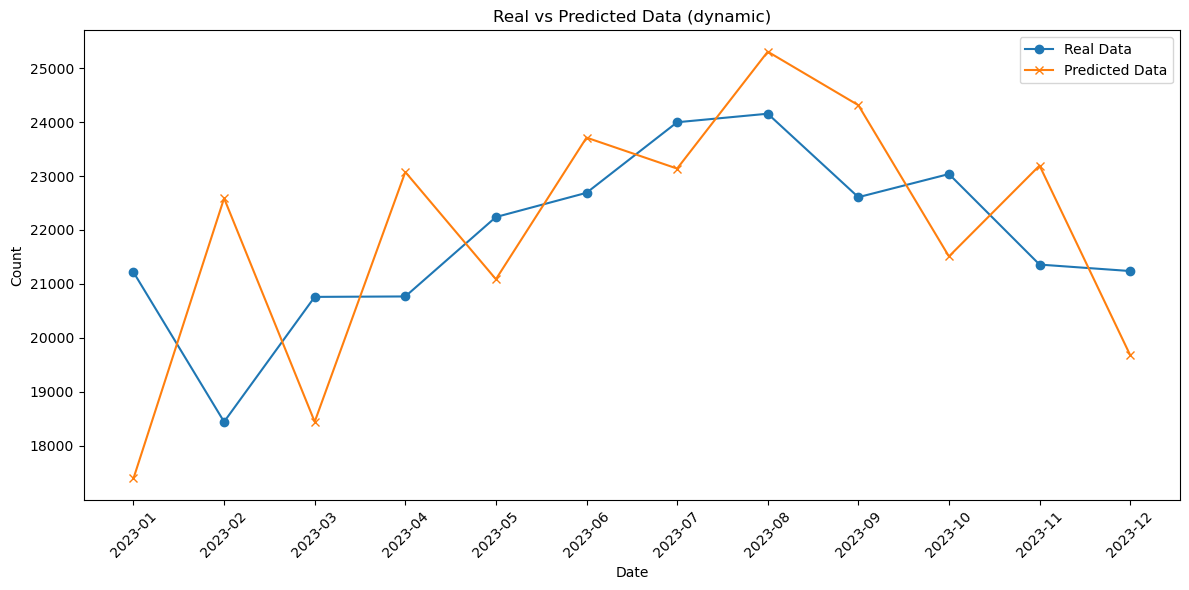

In [91]:
plt.figure(figsize=(12, 6))

plt.plot(df_compare_12.index, df_compare_12['real_data'], label='Real Data', marker='o')
plt.plot(df_compare_12.index, df_compare_12['predict_data'], label='Predicted Data', marker='x')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Real vs Predicted Data (dynamic)')

plt.legend()

plt.xticks(df_compare_12.index,rotation=45) 
plt.tight_layout()
plt.show()

In [92]:
print(df_compare_12['dev_rate'].median())
print(df_compare_12['dev_rate'].mean())

0.005000000000000001
0.006666666666666665


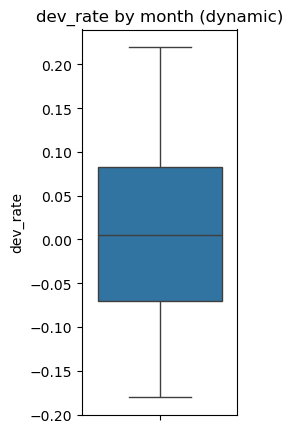

In [78]:
plt.figure(figsize=(2, 5))

sns.boxplot(y='dev_rate',data=df_compare_12)
plt.title('dev_rate by month (dynamic)')
plt.show()

##### >> the median of deviation rate is almost 0.0, and most of the rates are in 10%.

In [80]:
df_train = df_1823_m[(df_1823_m.index >= '2023-01')]
model_12 = pm.auto_arima(df_train, start_p=0, start_q=0, start_order=0, max_p=5 ,max_q=5, max_order=5, test='adf', seasonal=True) 
df_predict = model_12.predict(n_periods = 1)
df_predict.round(0).astype(int)

2024-01-01    20428
Freq: MS, dtype: int64

##### >> predict: in 2024-01, there will be 20428 records in Chicago. 

#### 3. records amount analysis by type -- fail

In [31]:
df_2223.head(5)

,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,11193643,JB102216,0000X S PULASKI RD,0460,BATTERY,SIMPLE,STREET,False,False,1122,...,28.0,26.0,08B,1149731.0,1899625.0,2018,05/04/2018 03:51:04 PM,41.880486,-87.725665,"(41.880486258, -87.725665179)"
2018-01-01,11192410,JB100300,034XX W FLOURNOY ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1133,...,24.0,27.0,08B,1153492.0,1896818.0,2018,05/04/2018 03:51:04 PM,41.872710,-87.711930,"(41.872709648, -87.711929688)"
2018-01-01,11192408,JB100280,009XX W BELMONT AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,1933,...,44.0,6.0,08B,1169640.0,1921442.0,2018,05/04/2018 03:51:04 PM,41.939943,-87.651925,"(41.939943264, -87.651924995)"
2018-01-01,11192406,JB100109,0000X N WABASH AVE,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,112,...,42.0,32.0,04B,1176806.0,1900538.0,2018,05/04/2018 03:51:04 PM,41.882422,-87.626221,"(41.882422496, -87.626221364)"
2018-01-01,11192403,JB100136,081XX S DREXEL AVE,041A,BATTERY,AGGRAVATED: HANDGUN,SIDEWALK,False,False,631,...,8.0,44.0,04B,1183647.0,1851316.0,2018,05/04/2018 03:51:04 PM,41.747196,-87.602638,"(41.74719631, -87.602638387)"


In [32]:
df_2223 = pd.read_csv('crimes_22_23.csv', parse_dates=['Date'], index_col = 2)
df_2223.index = pd.to_datetime(df_2223.index,format='%Y%m%d')
df_2223 = df_2223.sort_index()

df_2223_m_t = pd.DataFrame()
df_2223_m_t = df_2223.groupby([df_2223.index.year,df_2223.index.month,df_2223['Primary Type']]).size()
df_2223_m_t.index = df_2223_m_t.index.set_names(['year', 'month', 'Type'])
df_2223_m_t = df_2223_m_t.reset_index()

df_2223_m_t

,year,month,Type,0
0,2018,1,ARSON,26
1,2018,1,ASSAULT,1416
2,2018,1,BATTERY,3590
3,2018,1,BURGLARY,952
4,2018,1,CONCEALED CARRY LICENSE VIOLATION,4
...,...,...,...,...
1926,2023,7,ROBBERY,310
1927,2023,7,SEX OFFENSE,45
1928,2023,7,STALKING,15
1929,2023,7,THEFT,1242


In [33]:
df_2223_m_t['Year-Month'] = pd.to_datetime(df_2223_m_t[['year', 'month']].assign(Day=1))
df_2223_m_t['Year-Month'] = df_2223_m_t['Year-Month'].dt.to_period('M')
df_2223_m_t.set_index('Year-Month', inplace=True)
df_2223_m_t.drop(columns=['year', 'month'], inplace=True)
df_2223_m_t.columns = ['Type','count_m_t']

df_2223_m_t


,Type,count_m_t
Year-Month,,
2018-01,ARSON,26
2018-01,ASSAULT,1416
2018-01,BATTERY,3590
2018-01,BURGLARY,952
2018-01,CONCEALED CARRY LICENSE VIOLATION,4
...,...,...
2023-07,ROBBERY,310
2023-07,SEX OFFENSE,45
2023-07,STALKING,15


In [34]:
unique_types = df_2223_m_t['Type'].unique()
unique_types

array(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY',
       'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT',
       'CRIMINAL DAMAGE', 'CRIMINAL SEXUAL ASSAULT', 'CRIMINAL TRESPASS',
       'DECEPTIVE PRACTICE', 'GAMBLING', 'HOMICIDE', 'HUMAN TRAFFICKING',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING',
       'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT', 'NARCOTICS',
       'NON-CRIMINAL', 'OBSCENITY', 'OFFENSE INVOLVING CHILDREN',
       'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC PEACE VIOLATION',
       'ROBBERY', 'SEX OFFENSE', 'STALKING', 'THEFT', 'WEAPONS VIOLATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'PUBLIC INDECENCY',
       'OTHER NARCOTIC VIOLATION', 'RITUALISM'], dtype=object)

In [35]:
df_2223_m_t_THEFT = df_2223_m_t[df_2223_m_t['Type'] == 'THEFT']
df_2223_m_t_THEFT

,Type,count_m_t
Year-Month,,
2018-01,THEFT,4855
2018-02,THEFT,3900
2018-03,THEFT,4751
2018-04,THEFT,4999
2018-05,THEFT,5738
...,...,...
2023-03,THEFT,4442
2023-04,THEFT,4320
2023-05,THEFT,4670


In [36]:
df_compare_m_t = pd.DataFrame(columns=['real_data', 'predict_data', 'deviation', 'dev_rate'])

for i in range(12):
    df_train = df_2223_m_t_THEFT[(df_2223_m_t_THEFT.index >= '2021-07')]
    df_train = df_train.iloc[i:i+11]
    model_t = pm.auto_arima(df_2223_m_t_THEFT['count_m_t'], start_p=0, start_q=0, start_order=0, max_p=5 ,max_q=5, max_order=5, test='adf', seasonal=True) 
    df_predict = model_t.predict(n_periods = 1)
    time = (pd.to_datetime('2022-07') + pd.DateOffset(months=i)).normalize()

    real_data = df_2223_m_t_THEFT.loc[time.strftime('%Y-%m'), 'count_m_t']
    predict_data = int(df_predict[0].round(0))
    deviation = predict_data - real_data
    dev_rate = (deviation / real_data).round(2)

    df_compare_m_t.loc[time] = [real_data, predict_data, deviation, dev_rate]

print(df_compare_m_t)

/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_7200/539793737.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))
/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_7200/539793737.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))
/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_7200/539793737.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

            real_data  predict_data  deviation  dev_rate
2022-07-01     5733.0         564.0    -5169.0     -0.90
2022-08-01     5243.0         564.0    -4679.0     -0.89
2022-09-01     5115.0         564.0    -4551.0     -0.89
2022-10-01     5241.0         564.0    -4677.0     -0.89
2022-11-01     4714.0         564.0    -4150.0     -0.88
2022-12-01     4409.0         564.0    -3845.0     -0.87
2023-01-01     4281.0         564.0    -3717.0     -0.87
2023-02-01     3807.0         564.0    -3243.0     -0.85
2023-03-01     4442.0         564.0    -3878.0     -0.87
2023-04-01     4320.0         564.0    -3756.0     -0.87
2023-05-01     4670.0         564.0    -4106.0     -0.88
2023-06-01     4891.0         564.0    -4327.0     -0.88


/var/folders/xl/v2d6_bws3352wtfw95r6pg6r0000gn/T/ipykernel_7200/539793737.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  predict_data = int(df_predict[0].round(0))


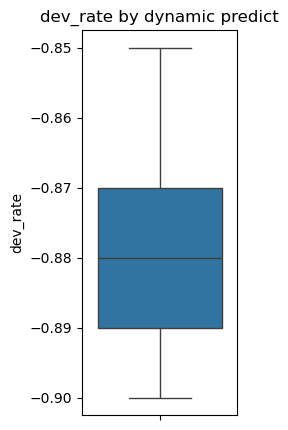

In [37]:
plt.figure(figsize=(2, 5))

sns.boxplot(y='dev_rate',data=df_compare_m_t)
plt.title('dev_rate by dynamic predict')
plt.show()